In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.regularizers import l1
import sys
sys.path.append('..')
from src.data_augmentation import *
from src.folder_preparation import *
import seaborn as sns
from tensorflow.keras import layers
import sklearn.metrics as metrics
import matplotlib.pyplot as pyplot
from keras.models import Model
from numpy import expand_dims
from copy import deepcopy

### resize and move data into folders with train and validation subdirectories
#### <font color='red'> only run once!</font>

In [3]:
# target_dir = Path('../simplifed-data-only-oranges')
# resize_and_move_images_to_train_val_folders(target_dir=target_dir,
#                                            split_ratio=0.1,
#                                            image_format='.png',
#                                            target_size=255)

### create dataset

In [4]:
from tensorflow import keras
import matplotlib.pyplot as plt

In [5]:
batch_size = 4
img_height = 255
img_width = 192

In [6]:
train_dir = Path('./split_simplifed-data-only-oranges/train')
val_dir = Path('./split_simplifed-data-only-oranges/validation')

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size=batch_size
)

Found 963 files belonging to 10 classes.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 112 files belonging to 10 classes.


### visualize the data

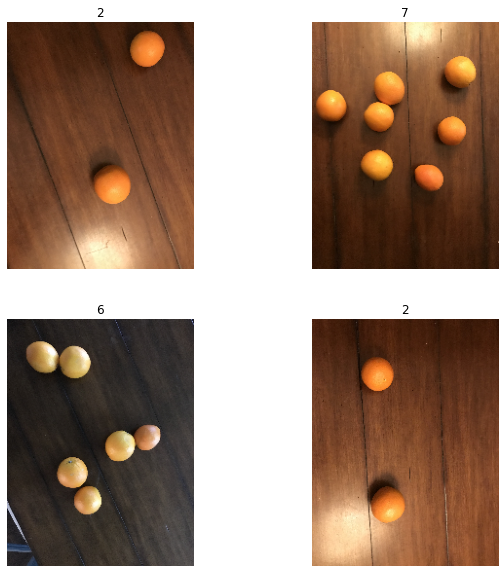

In [9]:
class_names = train_ds.class_names
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### standardize data

In [10]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x),y))

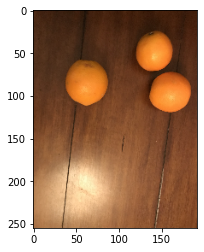

In [12]:
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
plt.imshow(first_image)

### configure dataset for performance

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [14]:
train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### train a model

In [15]:
# num_classes = 10
# model = tf.keras.Sequential([
#     layers.Conv2D(8,3,activation='relu'),
#     layers.MaxPool2D(),
#     layers.Conv2D(16,3,activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(32,activation='relu'),
#     layers.Dense(num_classes)
# ])

In [16]:
num_classes = 10
model = tf.keras.Sequential([
    layers.Conv2D(16,3,activation='relu',activity_regularizer=l1(0.01)),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,activation='relu',activity_regularizer=l1(0.01)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32,activation='relu',activity_regularizer=l1(0.001)),
    layers.Dense(num_classes)
])

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [18]:
# model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

In [19]:
normalized_train_ds

<MapDataset shapes: ((None, 255, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [20]:
print('{} train and {} val before ignoring errors'.format(len(train_ds),
                                                          len(val_ds)))
train_ds = train_ds.apply(tf.data.experimental.ignore_errors())
val_ds = val_ds.apply(tf.data.experimental.ignore_errors())
print('{} train and {} val after ignoring errors'.format(len(train_ds)
                                                          ,len(val_ds)))

241 train and 28 val before ignoring errors
241 train and 28 val after ignoring errors


In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200
)

Epoch 1/200
241/241 [==============================] - 15s 64ms/step - loss: 11.6253 - accuracy: 0.1194 - val_loss: 2.5229 - val_accuracy: 0.1429
Epoch 2/200
241/241 [==============================] - 14s 59ms/step - loss: 2.4358 - accuracy: 0.1485 - val_loss: 2.3999 - val_accuracy: 0.1250
Epoch 3/200
241/241 [==============================] - 14s 59ms/step - loss: 2.3611 - accuracy: 0.1391 - val_loss: 2.3488 - val_accuracy: 0.1250
Epoch 4/200
241/241 [==============================] - 14s 60ms/step - loss: 2.3276 - accuracy: 0.1277 - val_loss: 2.3233 - val_accuracy: 0.1339
Epoch 5/200
241/241 [==============================] - 15s 61ms/step - loss: 2.3104 - accuracy: 0.1288 - val_loss: 2.3095 - val_accuracy: 0.1250
Epoch 6/200
241/241 [==============================] - 15s 61ms/step - loss: 2.3007 - accuracy: 0.1298 - val_loss: 2.3014 - val_accuracy: 0.1250
Epoch 7/200
241/241 [==============================] - 15s 61ms/step - loss: 2.2946 - accuracy: 0.1308 - val_loss: 2.2967 - val_a

241/241 [==============================] - 15s 63ms/step - loss: 0.1159 - accuracy: 0.9927 - val_loss: 4.1781 - val_accuracy: 0.1786
Epoch 58/200
241/241 [==============================] - 15s 62ms/step - loss: 0.1330 - accuracy: 0.9907 - val_loss: 4.4734 - val_accuracy: 0.1786
Epoch 59/200
241/241 [==============================] - 15s 62ms/step - loss: 0.1203 - accuracy: 0.9907 - val_loss: 4.2688 - val_accuracy: 0.1964
Epoch 60/200
241/241 [==============================] - 15s 63ms/step - loss: 0.1166 - accuracy: 0.9938 - val_loss: 4.2348 - val_accuracy: 0.2054
Epoch 61/200
241/241 [==============================] - 15s 64ms/step - loss: 0.1148 - accuracy: 0.9948 - val_loss: 4.3219 - val_accuracy: 0.1696
Epoch 62/200
241/241 [==============================] - 15s 64ms/step - loss: 0.1169 - accuracy: 0.9886 - val_loss: 4.2838 - val_accuracy: 0.1964
Epoch 63/200
241/241 [==============================] - 16s 65ms/step - loss: 0.1087 - accuracy: 0.9917 - val_loss: 4.2572 - val_accuracy

241/241 [==============================] - 16s 66ms/step - loss: 0.0702 - accuracy: 0.9990 - val_loss: 4.8987 - val_accuracy: 0.1964
Epoch 114/200
241/241 [==============================] - 16s 67ms/step - loss: 0.0663 - accuracy: 0.9969 - val_loss: 5.0408 - val_accuracy: 0.1518
Epoch 115/200
241/241 [==============================] - 16s 68ms/step - loss: 0.0667 - accuracy: 0.9969 - val_loss: 5.2566 - val_accuracy: 0.1607
Epoch 116/200
241/241 [==============================] - 16s 68ms/step - loss: 0.0719 - accuracy: 0.9958 - val_loss: 5.1116 - val_accuracy: 0.1607
Epoch 117/200
241/241 [==============================] - 16s 67ms/step - loss: 0.0596 - accuracy: 0.9990 - val_loss: 4.7153 - val_accuracy: 0.1875
Epoch 118/200
241/241 [==============================] - 16s 66ms/step - loss: 0.0685 - accuracy: 0.9969 - val_loss: 5.0184 - val_accuracy: 0.1696
Epoch 119/200
241/241 [==============================] - 15s 64ms/step - loss: 0.0573 - accuracy: 0.9990 - val_loss: 4.8037 - val_ac

Epoch 169/200
241/241 [==============================] - 17s 71ms/step - loss: 0.0501 - accuracy: 0.9979 - val_loss: 5.3493 - val_accuracy: 0.1875
Epoch 170/200
241/241 [==============================] - 17s 72ms/step - loss: 0.0523 - accuracy: 0.9969 - val_loss: 5.9117 - val_accuracy: 0.2054
Epoch 171/200
241/241 [==============================] - 17s 70ms/step - loss: 0.0465 - accuracy: 0.9990 - val_loss: 5.0801 - val_accuracy: 0.2054
Epoch 172/200
241/241 [==============================] - 16s 67ms/step - loss: 0.0472 - accuracy: 0.9969 - val_loss: 4.9101 - val_accuracy: 0.2054
Epoch 173/200
241/241 [==============================] - 16s 66ms/step - loss: 0.0623 - accuracy: 0.9969 - val_loss: 5.1657 - val_accuracy: 0.2143
Epoch 174/200
241/241 [==============================] - 16s 66ms/step - loss: 0.0600 - accuracy: 0.9958 - val_loss: 5.2548 - val_accuracy: 0.2054
Epoch 175/200
241/241 [==============================] - 17s 69ms/step - loss: 0.0595 - accuracy: 0.9990 - val_loss: 5

In [22]:
stop here

SyntaxError: invalid syntax (<ipython-input-22-a96ba3aab008>, line 1)

### model evaluation

In [ ]:
predictions = model.predict_generator(val_ds)

In [ ]:
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
predicted_classes

In [ ]:
labels = np.array([x[1].numpy() for x in list(val_ds)])

In [ ]:
ground_truth = np.array(list(np.concatenate(labels, axis=0 )))

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)  # shape=(12, 12)

In [ ]:
cm_labels = list(np.sort(list(map(int,class_names))))

In [ ]:
import pandas as pd

In [ ]:
df_cm = pd.DataFrame(confusion_matrix,columns=cm_labels,index = cm_labels)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cm/len(df_cm),
           cmap='Blues',
           annot=True)
plt.title('Confusion matrix')

### visualizing training history

In [ ]:
history.history

In [ ]:
epochs = 20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)


In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### visualize filters

In [ ]:
model.summary()

In [ ]:
for layer in model.layers:
    print(layer.name)

In [ ]:
layer = model.layers[2]
print(layer.name)

In [ ]:
filters,biases = layer.get_weights()
print(layer.name,filters.shape)

In [ ]:
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

In [ ]:
f_min, f_max = filters.min(),filters.max()
filters = (filters-f_min)/(f_max-f_min)

In [ ]:
plt.figure(figsize=(10,10))
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j])
        ix += 1
# show the figure
pyplot.show()

### <font color='purple'>observation</font>
### <font color='purple'>*we see that light directions have been random which is consistent with our data gathering procedure*</font>

### visualize featuremaps

In [ ]:
plt.imshow(first_image)

In [ ]:
#list all convolutional layers
for i in range(len(model.layers)):
    layer=model.layers[i]
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

In [ ]:
model_fm=Model(inputs=model.inputs,outputs=model.layers[0].output)

In [ ]:
img = expand_dims(first_image,axis=0)

In [ ]:
feature_maps=model_fm.predict(img)

## LAYER 1

In [ ]:
plt.figure(figsize=(10,10))
dim1=8
dim2=4
ix = 1
for _ in range(dim1):
    for _ in range(dim2):
        # specify subplot and turn of axis
        ax = pyplot.subplot(dim1, dim2, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1])
        ix += 1
# show the figure
pyplot.show()

### visualize all blocks

In [ ]:
# redefine model to output right after the first hidden layer
ixs = [0,2,4]
outputs = [model.layers[i].output for i in ixs]
model_fm = Model(inputs=model.inputs, outputs=outputs)
# get feature map for first hidden layer
feature_maps = model_fm.predict(img)

In [ ]:
dim1=8
dim2=4
ix = 1
for fmap in feature_maps:
    plt.figure(figsize=(20,20))
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(dim1*dim2):
        # specify subplot and turn of axis
        ax = pyplot.subplot(dim1, dim2, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(fmap[0, :, :, ix-1])
        ix += 1
    print('---------------------------------------------')
    # show the figure
    pyplot.show()

In [ ]:
model.summary()